In [153]:
# notch filter, butterworth, fourier transformation, laplas transformation, 

In [1]:
# IMPORT EVERYTHING****!!!
from Architectures.AE_ADJ import AE # for some fucking reason importing this makes it not work? (reconstructs everything around the brain somehow)

from Data.load import load, load_middle_slices
from Visualizations.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE, MSE

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, Model, models, Input, activations, regularizers
from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import math
import nibabel as nib
from tqdm import tqdm

c:\Users\kiran\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from ...DementiaMRI.Architectures.VAE import VAE
#from Data.load import load
#from Architectures.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from Metrics.metrics import NMSE, SSIM, NRMSE, MSE
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss

import glob

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

from skimage.metrics import structural_similarity as ssim

import time
import math
import nibabel as nib
import json

import keras
# TODO: Add skip connections

import os
import pickle
from tensorflow.keras import layers, Model, activations, backend as K, ops, losses
import tensorflow as tf
import numpy as np
import keras
from keras import ops
from keras import layers, Model, activations


class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon
    
        #epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
        #return mean + K.exp(0.5 * log_var) * epsilon

#def sampling(self, args):
#    mean, log_var = args
#    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
#    return mean + K.exp(0.5 * log_var) * epsilon

class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                loss_fn="mse", #of any other funciton
                learning_rate=1e-3,
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        #physical_devices = tf.config.list_physical_devices('GPU')
        #for device in tf.config.list_physical_devices('GPU'):
        #    tf.config.experimental.set_memory_growth(device, True)

        # if len(physical_devices) > 0:
            #tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        if len(self.input_shape) == 4: 
            self.input_shape = (list(self.input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
        if len(self.input_shape) == 3:
            self.input_shape = (list(self.input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
        print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        x = self.add_layers(x, self.encoder_layers)

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)

        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            # z = layers.Lambda(self.sampling, name="z")([self.mean, self.log_var])
            z = Sampling()([self.mean, self.log_var])
            self.encoder = Model(input_layer, [self.mean, self.log_var, z], name="encoder")
        else:
            x = layers.Dense(self.latent_dim, activation="leaky_relu")(x)
            self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=(self.latent_dim,)) 

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(pre_flatten_shape[1:]), activation="leaky_relu")(latent_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        x = self.add_layers(x, self.decoder_layers)
        
        self.decoder = Model(latent_input, x, name="decoder")
        
        # 3. Combine the encoder and decoder into a full VAE
        if self.VAE_model:
            mean, log_var, z = self.encoder(input_layer)
            autoencoder_output = self.decoder(z)
            self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")

            # Add KL divergence loss
            reconstruction_loss = keras.losses.binary_crossentropy(input_layer, autoencoder_output) * self.input_dim
            kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
            vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
            
            self.autoencoder.add_loss(vae_loss)
            self.autoencoder.add_metric(reconstruction_loss, name='reconstruction_loss')
            self.autoencoder.add_metric(kl_loss, name='kl_loss')

            #mean, log_var, z = self.encoder(input_layer)
            #reconstructed = self.decoder(z)
            #kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
            #kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
            #self.add_loss(kl_loss)

            #mean, log_var, z = self.encoder(input_layer)
            # reconstructed = self.decoder(z)
            #kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var))#*self.lambda_
            #kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
            #kl_loss = tf.reduce_mean(kl_loss)  # To average over the batch
            #self.add_loss(kl_loss)
        else:
            autoencoder_output = self.decoder(self.encoder(input_layer))
            self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
    
        #self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        
        # 4. GPU or CPU assignment (based on self.GPU)
        #loss_fn = self.vae_loss if self.VAE_model else self.loss
        #optimizer = Adam(learning_rate=self.learning_rate)
        device = '/GPU:0' if self.GPU and tf.config.list_physical_devices('GPU') else '/CPU:0'
        #with tf.device(device):
        #    self.autoencoder.compile(
        #        optimizer=Adam(learning_rate=self.learning_rate),
        #        loss=loss_fn
        #    )

        self.history = {'loss': [], 'reconstruction_loss': [], 'kl_loss': [], 'val_loss': []}

    def add_layers(self, x, layers):
        for layer in layers:
            
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
            if self.debug:
                print(f"After {x.shape}: {layer}")
        return x

    def call(self, inputs):
        print("okodka")
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, x_test, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()

        # No reason to delete the loss history, if we stopped the sim at epoch10,
        # then we can continue it at another point
        if not hasattr(self, "history") or not self.history:
            #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
            #self.history.history = {"loss": [], "val_loss": []}
            self.history = {"loss": [], "val_loss": []}

        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        #validation_split=0.2,
                        validation_data=(x_test, x_test),
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0 and not self.VAE_model:
                        self.save(save_path, name=f"{self.name}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            print(type(self.autoencoder), x_train.shape)
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        #validation_split=0.2,
                        validation_data=(x_test, x_test),
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0: # and not self.VAE_model:
                    print(self.name)
                    self.save(save_path, name=f"{self.name}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history
    
    # def call(self, inputs):
    #     #print("GODAMN")
    #     #reconstruction_loss = self.loss_fn(y_true, y_pred)
    #     mean, log_var, z = self.encoder(inputs)
    #     reconstructed = self.decoder(z)
    #     #kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
    #     kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
    #     self.add_loss(kl_loss)
    #     return 0

    # def vae_loss2(self, inputs):
    #     z, mu, logvar = self.encoder(inputs)
    #     reconstructed = self.decoder(z)
    #     kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
    #     self.add_loss(kl_loss)
    #     return reconstructed
    
    """
    def call(self, y_true, y_pred):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed
    """
    
    #def vae_loss(self, y_true, y_pred):
    #    """Compute the VAE loss (reconstruction loss + KL divergence loss)."""
    #    # Reconstruction loss (SSIM loss)
    #    reconstruction_loss = self.loss(y_true, y_pred)
    #    # Extract mean and log variance from the encoder's output
    #    mean, log_var, _ = self.encoder(y_true)  # Use actual values, not placeholders
    #    # KL divergence loss
    #    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
    #    # Total loss
    #    return K.mean(reconstruction_loss + kl_loss)

    """
     def vae_loss_old(self, y_true, y_pred):
        ""Compute the VAE loss (reconstruction loss + KL divergence loss).""
        reconstruction_loss = self.loss(y_true, y_pred)

        # KL divergence loss
        # mean, log_var = self.encoder.input
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)

        # kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)

    def vae_loss(self, y_true, y_pred):
        ""Compute the VAE loss (reconstruction loss + KL divergence loss).""

        # Reconstruction loss (SSIM loss)
        reconstruction_loss = self.loss(y_true, y_pred)

        # Extract mean and log variance from the encoder's output
        mean, log_var, _ = self.encoder(y_true)  # Use actual values, not placeholders

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)

    def sampling(self, args):
        mean, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
        return mean + K.exp(0.5 * log_var) * epsilon
    """ 

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, models_path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk, and additional initialization data."""
        # Define the folder path where models will be saved
        model_folder = os.path.join(models_path, f"{name}")
        epoch_folder = os.path.join(model_folder, "epoch_"+str(len(self.history["loss"])))
        os.makedirs(model_folder, exist_ok=True)
        os.makedirs(epoch_folder, exist_ok=True)
        
        # Save the models to the folder
        #self.autoencoder.save(os.path.join(epoch_folder, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(epoch_folder, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(epoch_folder, f"{name}_decoder.keras"))
        print(f"Models saved to {epoch_folder} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

        # Save loss history if available
        if self.history is not None:
            history_path = os.path.join(epoch_folder, f"{name}_loss_history.json")
            with open(history_path, 'w') as f:
                json.dump(self.history, f)
            print(f"Loss history saved to {history_path}")

        # Convert the layers and other details to strings
        try:
            print(name)
        except:
            print("\n\nname not found (!!!) \n\n")

        model_details = {
            "input_shape": str(self.input_shape),
            "latent_dim": str(self.latent_dim),
            "encoder_layers": str(self.encoder_layers),
            "decoder_layers": str(self.decoder_layers),
            "name": str(name),
            "loss": str(self.loss_fn.__name__),
            "learning_rate": str(self.learning_rate),
            "VAE_model": str(self.VAE_model),
            "debug": str(self.debug),
            "GPU": str(self.GPU)
        }

        # Save the model details (converted to strings) in a JSON file
        details_path = os.path.join(epoch_folder, f"{name}_model_details.json")
        with open(details_path, 'w') as f:
            json.dump(model_details, f, indent=4)
        print(f"Model details saved to {details_path}")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")
        history_path = os.path.join(path, f"{name}_loss_history.json")
        details_path = os.path.join(path, f"{name}_model_details.json")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")
        
        autoencoder = tf.keras.models.load_model(autoencoder_path, custom_objects={"MSE_loss": MSE_loss})
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True

        # Compile the loaded model manually
        ae.autoencoder.compile(optimizer='adam')

        print("Models loaded and compiled successfully.")

        with open(history_path) as f:
            ae.history = json.load(f) #ae.history = {'loss': [], 'val_loss': []}  

        with open(details_path) as f:
            ae.details = json.load(f)
            
            # Ensure these are boolean values, convert them if necessary # [False, True]["False" == "True"]
            ae.input_shape = eval(ae.details["input_shape"])
            ae.latent_dim = eval(ae.details["latent_dim"])
            ae.encoder_layers = ae.details["encoder_layers"]
            ae.decoder_layers = ae.details["decoder_layers"]
            ae.name = ae.details["name"]
            ae.loss = {"MSE_loss": MSE_loss, "SSIM_loss": SSIM_loss}[ae.details["loss"]]
            # ae.loss = ae.details["loss"]
            ae.learning_rate = ae.details["learning_rate"]
            ae.VAE_model = eval(ae.details["VAE_model"])
            ae.debug = eval(ae.details["debug"])
            ae.GPU = eval(ae.details["GPU"])

        return ae

In [3]:
groups = {}
for group in tqdm(["CN","MCI","AD"],"Opening faster"):
    groups[group]=np.load(open(f"Data/D2-{group}-A.npy","br"))

Opening faster: 100%|██████████| 3/3 [00:00<00:00, 87.29it/s]


In [ ]:
# from ...DementiaMRI.Architectures.VAE import VAE
#from Data.load import load
#from Architectures.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from Metrics.metrics import NMSE, SSIM, NRMSE, MSE
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss

import glob

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

from skimage.metrics import structural_similarity as ssim

import time
import math
import nibabel as nib
import json

# TODO: Add skip connections

class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                loss_fn="mse", #of any other funciton
                learning_rate=1e-3,
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        #physical_devices = tf.config.list_physical_devices('GPU')
        for device in tf.config.list_physical_devices('GPU'):
            tf.config.experimental.set_memory_growth(device, True)

        # if len(physical_devices) > 0:
            #tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        if len(self.input_shape) == 4: 
            self.input_shape = (list(self.input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
        if len(self.input_shape) == 3:
            self.input_shape = (list(self.input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
        print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        x = self.add_layers(x, self.encoder_layers)

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)

        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            #z = layers.Lambda(Sampling, name="z")([self.mean, self.log_var])
            z = Sampling()([self.mean, self.log_var])
            self.encoder = Model(input_layer, [self.mean, self.log_var, z], name="encoder")
        else:
            x = layers.Dense(self.latent_dim, activation="leaky_relu")(x)
            self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=(self.latent_dim,)) 

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(pre_flatten_shape[1:]), activation="leaky_relu")(latent_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        x = self.add_layers(x, self.decoder_layers)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full VAE
        if self.VAE_model:
            mean, log_var, z = self.encoder(input_layer)
            autoencoder_output = self.decoder(z)
        else:
            autoencoder_output = self.decoder(self.encoder(input_layer))

        # 3. Combine the encoder and decoder into a full autoencoder
        self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        
        # 4. GPU or CPU assignment (based on self.GPU)
        optimizer = Adam(learning_rate=self.learning_rate)
        loss_fn = self.vae_loss if self.VAE_model else self.loss
        
        with tf.device('/GPU:0' if self.GPU and tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.autoencoder.compile(optimizer=optimizer, loss=loss_fn)

    def add_layers(self, x, layers):
        for layer in layers:
            
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
            if self.debug:
                print(f"After {x.shape}: {layer}")
        return x

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, x_test, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()

        # No reason to delete the loss history, if we stopped the sim at epoch10,
        # then we can continue it at another point
        if not hasattr(self, "history") or not self.history:
            #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
            #self.history.history = {"loss": [], "val_loss": []}
            self.history = {"loss": [], "val_loss": []}

        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.vae.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        #validation_split=0.2,
                        validation_data=(x_test, x_test),
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0: # and not self.VAE_model:
                        self.save(save_path, name=f"{self.name}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            print(type(self.autoencoder), x_train.shape)
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        #validation_split=0.2,
                        validation_data=(x_test, x_test),
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0: # and not self.VAE_model:
                    print(self.name)
                    self.save(save_path, name=f"{self.name}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history

    def vae_loss_old(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""
        reconstruction_loss = self.loss_fn(y_true, y_pred)

        # KL divergence loss
        # mean, log_var = self.encoder.input
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)

        # kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)
    
    def vae_loss(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""

        # Reconstruction loss (SSIM loss)
        reconstruction_loss = self.loss_fn(y_true, y_pred)

        # Extract mean and log variance from the encoder's output
        mean, log_var, _ = self.encoder(y_true)  # Use actual values, not placeholders

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)

    def sampling(self, args):
        mean, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
        return mean + K.exp(0.5 * log_var) * epsilon
    
    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, models_path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk, and additional initialization data."""
        # Define the folder path where models will be saved
        model_folder = os.path.join(models_path, f"{name}")
        epoch_folder = os.path.join(model_folder, "epoch_"+str(len(self.history["loss"])))
        os.makedirs(model_folder, exist_ok=True)
        os.makedirs(epoch_folder, exist_ok=True)
        
        # Save the models to the folder
        self.autoencoder.save(os.path.join(epoch_folder, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(epoch_folder, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(epoch_folder, f"{name}_decoder.keras"))
        print(f"Models saved to {epoch_folder} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

        # Save loss history if available
        if self.history is not None:
            history_path = os.path.join(epoch_folder, f"{name}_loss_history.json")
            with open(history_path, 'w') as f:
                json.dump(self.history, f)
            print(f"Loss history saved to {history_path}")

        # Convert the layers and other details to strings
        try:
            print(name)
        except:
            print("\n\nname not found (!!!) \n\n")

        model_details = {
            "input_shape": str(self.input_shape),
            "latent_dim": str(self.latent_dim),
            "encoder_layers": str(self.encoder_layers),
            "decoder_layers": str(self.decoder_layers),
            "name": str(name),
            "loss_fn": str(self.loss_fn.__name__),
            "learning_rate": str(self.learning_rate),
            "VAE_model": str(self.VAE_model),
            "debug": str(self.debug),
            "GPU": str(self.GPU)
        }

        # Save the model details (converted to strings) in a JSON file
        details_path = os.path.join(epoch_folder, f"{name}_model_details.json")
        with open(details_path, 'w') as f:
            json.dump(model_details, f, indent=4)
        print(f"Model details saved to {details_path}")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")
        history_path = os.path.join(path, f"{name}_loss_history.json")
        details_path = os.path.join(path, f"{name}_model_details.json")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")
        
        
        autoencoder = tf.keras.models.load_model(autoencoder_path, custom_objects={"MSE_loss": MSE_loss})
        """
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)
        
        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True

        # Compile the loaded model manually
        ae.autoencoder.compile(optimizer='adam')

        print("Models loaded and compiled successfully.")

        with open(history_path) as f:
            ae.history = json.load(f) #ae.history = {'loss': [], 'val_loss': []}  



        with open(details_path) as f:
            ae.details = json.load(f)
            
            # Ensure these are boolean values, convert them if necessary # [False, True]["False" == "True"]
            ae.input_shape = eval(ae.details["input_shape"])
            ae.latent_dim = eval(ae.details["latent_dim"])
            ae.encoder_layers = ae.details["encoder_layers"]
            ae.decoder_layers = ae.details["decoder_layers"]
            ae.name = ae.details["name"]
            ae.loss_fn = {"MSE_loss": MSE_loss, "SSIM_loss": SSIM_loss}[ae.details["loss_fn"]]
            # ae.loss = ae.details["loss"]
            ae.learning_rate = ae.details["learning_rate"]
            ae.VAE_model = eval(ae.details["VAE_model"])
            ae.debug = eval(ae.details["debug"])
            ae.GPU = eval(ae.details["GPU"])
        
        return ae"""

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

# Define the VAE model
class VAE(keras.Model):
    def __init__(
            self,
            input_shape,
            latent_dim,
            encoder_layers,
            decoder_layers,
            name="AE",
            VAE_model=True,
            learning_rate=1e-3,
            output_activation="tanh",
            beta=1e-5,
            debug=False,
            GPU=False,
            hidden_activation=activations.leaky_relu,
            loss_fn="mse"
            ):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.name = name
        self.lambda_ = beta
        self.learning_rate = learning_rate
        #self.loss_fn = loss_fn
        
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.loss_fn = loss_fn
        self.hist = {'loss': [], 'val_loss': [], 'reconstruction_loss': [], 'kl_loss': []}
        
        # shape_changed=False
        #if input_shape[-1]>3:
        #    input_shape = list(input_shape) + [1]
        #    shape_changed=True
        #if len(input_shape)>4:
        #    input_shape = input_shape[-4:]
        #    shape_changed=True
        #if shape_changed: 
        #    print(f"Interpreted image shape: {tuple(input_shape)}")

        if len(self.input_shape) == 4: 
            self.input_shape = (list(self.input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
        if len(self.input_shape) == 3:
            self.input_shape = (list(self.input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
        print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # Encoder
        encoder_input_layer = x = layers.Input(shape=self.input_shape)
        x = self.add_layers(x, self.encoder_layers)
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        
        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            z = Sampling()([self.mean, self.log_var])
            self.encoder = Model(encoder_input_layer, [self.mean, self.log_var, z], name="encoder")
        else:
            x = layers.Dense(self.latent_dim, activation="leaky_relu")(x)
            self.encoder = Model(encoder_input_layer, x, name="encoder")

        # Reshape the latent vector back to the original spatial dimensions
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(pre_flatten_shape[1:5]), activation="relu")(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        x = self.add_layers(x, self.decoder_layers)
        
        self.decoder = Model(decoder_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full AE / VAE
        if self.VAE_model:
            z_mean, z_log_var, z = self.encoder(encoder_input_layer)
            autoencoder_output = self.decoder(z)
            self.autoencoder = Model(encoder_input_layer, autoencoder_output, name="autoencoder")
            
            # VAE loss
            reconstruction_loss = self.loss_fn(encoder_input_layer, autoencoder_output)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
            
            # Add losses and metrics
            self.autoencoder.add_loss(total_loss)
            self.autoencoder.add_metric(reconstruction_loss, name='reconstruction_loss')
            self.autoencoder.add_metric(kl_loss, name='kl_loss')
        else:
            autoencoder_output = self.decoder(self.encoder(encoder_input_layer))
            self.autoencoder = Model(encoder_input_layer, autoencoder_output, name="autoencoder")
        
        ##self.autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")
    
    def _build_encoder(self):
        encoder_input_layer = x = layers.Input(shape=self.input_shape)
        x = self.add_layers(x, self.encoder_layers)
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        
        if not self.VAE_model:
            x = layers.Dense(self.latent_dim, activation="leaky_relu")(x)
            self.encoder = Model(encoder_input_layer, x, name="encoder")
            return

        # VAE specific: Output mean and log variance
        self.mean = layers.Dense(self.latent_dim, name="mean")(x)
        self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
        z = Sampling()([self.mean, self.log_var])
        self.encoder = Model(encoder_input_layer, [self.mean, self.log_var, z], name="encoder")

    def add_layers(self, x, layers):
        for layer in layers:
            
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
            if self.debug:
                print(f"After {x.shape}: {layer}")
        return x
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        """A seperate train function to save models every n interval and do other usefull modifications"""
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        print(f"Training {self.name} on {'GPU' if self.GPU else 'CPU'}")
        print(f"Input shape: {x_train.shape}")

        for epoch in range(1, epochs + 1):
            history = self.fit(
                x_train, x_train,
                epochs=1,
                batch_size=batch_size,
                shuffle=True,
                validation_split=0.2,
                verbose=verbose
            )
            #print(history.history)
            #self.history["loss"].extend(history.history.get("loss", []))
            #self.history["val_loss"].extend(history.history.get("val_loss", []))
            #print(self.history.history)
            self.hist["loss"].extend(history.history["loss"])
            self.hist["val_loss"].extend(history.history["val_loss"])
            self.history = self.hist

            if save_path and epoch % save_interval == 0:
                #self.save(os.path.join(save_path, name=f"{self.name}_epoch{epoch}"))
                self.save(save_path, name=f"{self.name}")

        self.training_time = time.time() - start_time
        print(f"Training complete in {round(self.training_time, 2)}s")
        return self.history

    def call(self, inputs):
        print("okk")
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)
    
    def autoencode(self, x):
        latent = self.encode(x)
        if self.VAE_model:
            latent = latent[2]
        recon = self.decode(latent)
        return recon

    def save(self, model_path, name):
        """Save the VAE model, encoder, and decoder to disk."""
        model_folder = os.path.join(model_path, f"{name}")
        epoch_folder = os.path.join(model_folder, "epoch_"+str(len(self.hist["loss"])))
        os.makedirs(model_folder, exist_ok=True)
        os.makedirs(epoch_folder, exist_ok=True)

        self.encoder.save(os.path.join(epoch_folder, "encoder.keras"))
        self.decoder.save(os.path.join(epoch_folder, "decoder.keras"))
        print(f"Models saved to {epoch_folder} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

        
        # Save loss history if available
        if self.history is not None:
            history_path = os.path.join(epoch_folder, "history.json")
            with open(history_path, 'w') as f:
                json.dump(self.hist, f)
            print(f"Loss history saved to {history_path}")

        configs = {
            "input_shape": str(self.input_shape),
            "latent_dim": str(self.latent_dim),
            "encoder_layers": str(self.encoder_layers),
            "decoder_layers": str(self.decoder_layers),
            "name": str(name),
            #"loss": str(self.loss_fn.__name__),
            "learning_rate": str(self.learning_rate),
            "VAE_model": str(self.VAE_model),
            "debug": str(self.debug),
            "GPU": str(self.GPU)
        }

        # Save the model details (converted to strings) in a JSON file
        configs_path = os.path.join(epoch_folder, "configs.json")
        with open(configs_path, 'w') as f:
            json.dump(configs, f, indent=4)
        print(f"Model details saved to {configs_path}")

    @staticmethod
    def open(path):
        """Load the VAE model, encoder, and decoder from disk."""
        encoder = tf.keras.models.load_model(os.path.join(path, "encoder.keras"), custom_objects={'Sampling': Sampling})
        decoder = tf.keras.models.load_model(os.path.join(path, "decoder.keras"))
        
        # Create an instance of VAE without initializing models
        vae = VAE.__new__(VAE)
        vae.encoder = encoder
        vae.decoder = decoder

        with open(os.path.join(path, "history.json")) as f:
            vae.hist = json.load(f) #ae.history = {'loss': [], 'val_loss': []}  
            vae.history = vae.hist

        vae.name="ok"
        vae.built = True

        print("Models loaded successfully.")

        with open(os.path.join(path, "configs.json")) as f:
            vae.details = json.load(f)
            
            # Ensure these are boolean values, convert them if necessary # [False, True]["False" == "True"]
            vae.input_shape = eval(vae.details["input_shape"])
            vae.latent_dim = eval(vae.details["latent_dim"])
            vae.encoder_layers = vae.details["encoder_layers"]
            vae.decoder_layers = vae.details["decoder_layers"]
            vae.name = vae.details["name"]
            #vae.loss = {"MSE_loss": MSE_loss, "SSIM_loss": SSIM_loss}[vae.details["loss"]]
            # ae.loss = ae.details["loss"]
            vae.learning_rate = eval(vae.details["learning_rate"])
            vae.VAE_model = eval(vae.details["VAE_model"])
            vae.debug = eval(vae.details["debug"])
            vae.GPU = eval(vae.details["GPU"])

        # Now reassemble the full VAE model and compile
        #vae.full_model = vae.create_full_model()  # Assuming you have a method to create the full model
        #vae.full_model.compile(optimizer='adam')  # Compile the full model after loading components
        #vae.compile(optimizer="adam")
        #vae._compile_loss = None
        #vae._compile_metrics = None
        #vae._loss_tracker = None
        #super(VAE, vae).compile(optimizer="adam", loss="mse", metrics=None)

        return vae


In [ ]:

A2 = VAE(name="A2", input_shape=groups["CN"].shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, debug=False, loss_fn=SSIM_loss)


NameError: name 'VAE' is not defined

In [377]:
A2.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [378]:
train = groups["CN"][0:10]
#A2.fit(train, train, epochs=20, batch_size=32, verbose=True)
A2.train(groups["CN"], epochs=3, batch_size=128, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images", 
    save_interval=3)  # saves every 100 epoch btw


Training A2 on CPU
Input shape: (988, 80, 96)
okk
okk
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1846okk
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.1719 - val_loss: 0.0787
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0615 - val_loss: 0.0314
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0306 - val_loss: 0.0206
Models saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_3 as 'A2_autoencoder.keras', 'A2_encoder.keras', 'A2_decoder.keras'.
Loss history saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_3\history.json
Model details saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_3\configs.json
Training complete in 5.27s


{'loss': [0.13356420397758484, 0.05217882990837097, 0.030350837856531143],
 'val_loss': [0.07869058847427368, 0.03135443851351738, 0.02057446911931038],
 'reconstruction_loss': [],
 'kl_loss': []}

In [379]:
c = VAE.open(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_3")

Models loaded successfully.


In [ ]:
#c.loss
#c.compile(optimizer=keras.optimizers.Adam(), loss="mse")

AttributeError: 'VAE' object has no attribute '_dtype_policy'

In [303]:
#plt.imshow(c.decode(c.encode(groups["CN"][0:1])[0]))
#c.encode()
#c.autoencode(groups["CN"][0:3])

In [10]:

A2 = AE(name="A2", input_shape=groups["CN"].shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, loss=SSIM_loss)


Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 32)



In [11]:

for m in [A2]: #[A2,A4,A5]
    m.train(groups["CN"], groups["CN"], epochs=3, batch_size=128, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images", 
    save_interval=2)  # saves every 100 epoch btw


Training A2 on the CPU<class 'keras.src.models.functional.Functional'> (988, 80, 96)
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - loss: 2.2426 - val_loss: 0.9448
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - loss: 1.0297 - val_loss: 0.6764
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 0.6505 - val_loss: 0.5863
 - 10.87s


In [239]:
models_list = [AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_2\A2_autoencoder.keras")]

TypeError: Could not locate class 'method'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'method', 'config': 'vae_loss', 'registered_name': 'method'}

In [223]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os
import json

class VAE:
    def __init__(self, name="VAE", input_shape=(28, 28, 1), latent_dim=32, 
                 encoder_layers=None, decoder_layers=None, 
                 VAE_model=True, loss_fn=None, debug=False):
        """
        Initialize a Variational Autoencoder with custom encoder and decoder architectures.
        
        Args:
            name: Name of the model
            input_shape: Shape of input data (height, width, channels)
            latent_dim: Dimension of latent space
            encoder_layers: List of layer specifications for encoder
            decoder_layers: List of layer specifications for decoder
            VAE_model: If True, use variational autoencoder, otherwise standard autoencoder
            loss_fn: Custom loss function (if None, uses binary crossentropy with KL divergence for VAE)
            debug: If True, print layer shapes during architecture building
        """
        self.name = name
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers or []
        self.decoder_layers = decoder_layers or []
        self.is_vae = VAE_model
        self.custom_loss_fn = loss_fn
        self.debug = debug
        
        # Build the encoder, decoder, and full model
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        self.model = self._build_model()
        
        # Initialize history dictionary
        self.history = {'loss': [], 'val_loss': []}
        if self.is_vae:
            self.history.update({'reconstruction_loss': [], 'kl_loss': []})
    
    def add_layers(self, x, layers_spec):
        """
        Add layers to a model based on specifications.
        
        Args:
            x: Input tensor
            layers_spec: List of layer specifications. Each spec can be:
                        - A layer instance
                        - A tuple (layer_type, *args, **kwargs)
        
        Returns:
            Output tensor after adding all layers
        """
        for layer in layers_spec:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                
                # Handle 'leaky_relu' activation separately
                if layer_kwargs.get('activation') == 'leaky_relu':
                    layer_kwargs['activation'] = tf.keras.layers.LeakyReLU(0.2)
                
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            if self.debug:
                print(f"After {x.shape}: {layer}")
        
        return x
    
    def _build_encoder(self):
        """Build the encoder model."""
        encoder_inputs = keras.Input(shape=self.input_shape, name='encoder_input')
        
        # Add encoder layers
        x = encoder_inputs
        #if self.encoder_layers:
        x = self.add_layers(x, self.encoder_layers)
        
        # Flatten for dense layers
        x = layers.Flatten()(x)
        
        # For standard autoencoder
        if not self.is_vae:
            z = layers.Dense(self.latent_dim, name='z')(x)
            encoder = Model(encoder_inputs, z, name='encoder')
            return encoder
        
        # For VAE, add mean and log variance layers
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        
        # Sampling layer using reparameterization trick
        z = Sampling()([z_mean, z_log_var])
        
        # Create encoder model
        encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
        return encoder
    
    def _build_decoder(self):
        """Build the decoder model."""
        # Calculate the shape after flattening based on encoder architecture
        if self.encoder_layers:
            # Create a temporary model to compute output shape
            temp_input = keras.Input(shape=self.input_shape)
            temp_output = self.add_layers(temp_input, self.encoder_layers)
            conv_output_shape = temp_output.shape[1:]
            self.decoder_input_shape = conv_output_shape
        else:
            # If no encoder layers, assume flattened input
            self.decoder_input_shape = np.prod(self.input_shape)
        
        # Input for decoder is from latent space
        latent_inputs = keras.Input(shape=(self.latent_dim,), name='decoder_input')
        
        # If we have convolutional layers in decoder, we need to reshape
        x = latent_inputs
        if self.decoder_layers:
            # We need to reshape latent vector to match the first conv layer
            # First, dense layer to get enough features
            units = np.prod(self.decoder_input_shape)
            x = layers.Dense(units, activation='relu')(x)
            x = layers.Reshape(self.decoder_input_shape)(x)
            
            # Add decoder layers
            x = self.add_layers(x, self.decoder_layers)
        else:
            # If no decoder layers specified, use simple dense layers
            x = layers.Dense(np.prod(self.input_shape), activation='sigmoid')(x)
            x = layers.Reshape(self.input_shape)(x)
        
        # Create decoder model
        decoder = Model(latent_inputs, x, name='decoder')
        return decoder
    
    def _build_model(self):
        """Combine encoder and decoder into a full model."""
        inputs = keras.Input(shape=self.input_shape, name='model_input')
        
        if self.is_vae:
            # For VAE
            z_mean, z_log_var, z = self.encoder(inputs)
            outputs = self.decoder(z)
            
            # Create the model
            model = Model(inputs, outputs, name=self.name)
            
            # Add losses
            if self.custom_loss_fn:
                # Apply custom loss function
                reconstruction_loss = self.custom_loss_fn(inputs, outputs)
            else:
                # Default loss is binary crossentropy
                reconstruction_loss = tf.reduce_mean(
                    keras.losses.binary_crossentropy(
                        tf.keras.backend.flatten(inputs), 
                        tf.keras.backend.flatten(outputs)
                    ) * np.prod(self.input_shape)
                )
            
            # KL divergence regularization loss
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            
            # Total loss is reconstruction + KL divergence
            total_loss = reconstruction_loss + kl_loss
            
            # Add losses and metrics
            model.add_loss(total_loss)
            model.add_metric(reconstruction_loss, name='reconstruction_loss')
            model.add_metric(kl_loss, name='kl_loss')
            
        else:
            # For standard autoencoder
            z = self.encoder(inputs)
            outputs = self.decoder(z)
            
            # Create the model
            model = Model(inputs, outputs, name=self.name)
            
            if self.custom_loss_fn:
                model.add_loss(self.custom_loss_fn(inputs, outputs))
        
        return model
    
    def compile(self, optimizer='adam'):
        """Compile the model."""
        self.model.compile(optimizer=optimizer)
    
    def fit(self, x_train, epochs=10, batch_size=128, validation_data=None, verbose=1, callbacks=None):
        """Train the model."""
        # Custom callback to capture metrics
        class MetricsCallback(keras.callbacks.Callback):
            def __init__(self, history_dict):
                self.history_dict = history_dict
                
            def on_epoch_end(self, epoch, logs=None):
                for key, value in logs.items():
                    if key not in self.history_dict:
                        self.history_dict[key] = []
                    self.history_dict[key].append(float(value))
        
        # Set up callbacks
        history_callback = MetricsCallback(self.history)
        all_callbacks = [history_callback]
        if callbacks:
            all_callbacks.extend(callbacks)
        
        # Train the model
        self.model.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validation_data, validation_data) if validation_data is not None else None,
            callbacks=all_callbacks,
            verbose=verbose
        )
        
        return self.history
    
    def encode(self, x):
        """Encode data to latent space."""
        if self.is_vae:
            z_mean, _, _ = self.encoder.predict(x)
            return z_mean
        else:
            return self.encoder.predict(x)
    
    def decode(self, z):
        """Decode from latent space."""
        return self.decoder.predict(z)
    
    def reconstruct(self, x):
        """Reconstruct input data."""
        return self.model.predict(x)
    
    def generate(self, n_samples=1):
        """Generate samples from random points in latent space."""
        z_sample = np.random.normal(size=(n_samples, self.latent_dim))
        return self.decode(z_sample)
    
    def save_models(self, directory=None):
        """Save encoder, decoder, full model and training history."""
        if directory is None:
            directory = f"{self.name}_models"
        
        # Create directory if it doesn't exist
        os.makedirs(directory, exist_ok=True)
        
        # Save models
        self.encoder.save(os.path.join(directory, "encoder.h5"))
        self.decoder.save(os.path.join(directory, "decoder.h5"))
        self.model.save(os.path.join(directory, "full_model.h5"))
        
        # Save model configuration
        config = {
            'name': self.name,
            'input_shape': self.input_shape,
            'latent_dim': self.latent_dim,
            'is_vae': self.is_vae,
            # Cannot serialize layer specifications directly
        }
        
        with open(os.path.join(directory, "config.json"), 'w') as f:
            json.dump(config, f)
        
        # Save training history
        with open(os.path.join(directory, "history.json"), 'w') as f:
            json.dump(self.history, f)
    
    @classmethod
    def load_models(cls, directory, custom_loss_fn=None):
        """Load models and history from directory."""
        # Load configuration
        with open(os.path.join(directory, "config.json"), 'r') as f:
            config = json.load(f)
        
        # Create a new instance
        instance = cls(
            name=config['name'],
            input_shape=tuple(config['input_shape']),
            latent_dim=config['latent_dim'],
            VAE_model=config['is_vae'],
            loss_fn=custom_loss_fn
        )
        
        # Load the saved models
        instance.encoder = keras.models.load_model(os.path.join(directory, "encoder.h5"))
        instance.decoder = keras.models.load_model(os.path.join(directory, "decoder.h5"))
        instance.model = keras.models.load_model(os.path.join(directory, "full_model.h5"))
        
        # Load history
        with open(os.path.join(directory, "history.json"), 'r') as f:
            instance.history = json.load(f)
        
        return instance
    
    def plot_history(self):
        """Plot training history."""
        if self.is_vae:
            fig, ax = plt.subplots(1, 3, figsize=(18, 5))
            
            ax[0].plot(self.history['loss'])
            if 'val_loss' in self.history and self.history['val_loss']:
                ax[0].plot(self.history['val_loss'])
                ax[0].legend(['train', 'val'])
            ax[0].set_title('Total Loss')
            ax[0].set_xlabel('Epoch')
            
            ax[1].plot(self.history['reconstruction_loss'])
            ax[1].set_title('Reconstruction Loss')
            ax[1].set_xlabel('Epoch')
            
            ax[2].plot(self.history['kl_loss'])
            ax[2].set_title('KL Loss')
            ax[2].set_xlabel('Epoch')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 5))
            ax.plot(self.history['loss'])
            if 'val_loss' in self.history and self.history['val_loss']:
                ax.plot(self.history['val_loss'])
                ax.legend(['train', 'val'])
            ax.set_title('Loss')
            ax.set_xlabel('Epoch')
        
        plt.tight_layout()
        return fig


# Reparameterization trick layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the data."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Example usage:
if __name__ == "__main__":
    # Example custom layers
    encoder_layers = [
        (layers.Conv2D, 16, (3, 3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3, 3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'})
    ]
    
    decoder_layers = [
        (layers.Conv2D, 32, (3, 3), {'padding': 'same'}), 
        (layers.UpSampling2D, (2, 2)),
        (layers.Conv2D, 16, (3, 3), {'padding': 'same'}), 
        (layers.UpSampling2D, (2, 2)),
        (layers.Conv2D, 1, (3, 3), {'padding': 'same', 'activation': 'sigmoid'})
    ]
    
    # Load MNIST as example data
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((-1, 28, 28, 1))
    x_test = x_test.reshape((-1, 28, 28, 1))
    
    # Create VAE with custom layers and SSIM loss
    vae = VAE(
        name="A2", 
        input_shape=(28, 28, 1),
        latent_dim=16,
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        VAE_model=True,
        loss_fn=SSIM_loss,
        debug=True
    )
    
    vae.compile(optimizer='adam')
    vae.fit(x_train[:1000], epochs=5, batch_size=32, validation_data=x_test[:100])
    
    # Save models and history
    vae.save_models()
    
    # Plot and save training history
    fig = vae.plot_history()
    fig.savefig("A2_models/training_history.png")
    
    # Generate some reconstructions
    n = 10
    test_images = x_test[:n]
    reconstructed = vae.reconstruct(test_images)
    
    # Plot reconstructions
    fig, axes = plt.subplots(2, n, figsize=(20, 4))
    
    for i in range(n):
        # Original images
        axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
        
        # Reconstructed images
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.savefig("A2_models/reconstructions.png")

After (None, 14, 14, 16): (<class 'keras.src.layers.convolutional.conv2d.Conv2D'>, 16, (3, 3), {'strides': 2, 'padding': 'same', 'activation': <LeakyReLU name=leaky_re_lu_4, built=True>})
After (None, 7, 7, 32): (<class 'keras.src.layers.convolutional.conv2d.Conv2D'>, 32, (3, 3), {'strides': 2, 'padding': 'same', 'activation': <LeakyReLU name=leaky_re_lu_5, built=True>})
After (None, 14, 14, 16): (<class 'keras.src.layers.convolutional.conv2d.Conv2D'>, 16, (3, 3), {'strides': 2, 'padding': 'same', 'activation': <LeakyReLU name=leaky_re_lu_4, built=True>})
After (None, 7, 7, 32): (<class 'keras.src.layers.convolutional.conv2d.Conv2D'>, 32, (3, 3), {'strides': 2, 'padding': 'same', 'activation': <LeakyReLU name=leaky_re_lu_5, built=True>})
After (None, 7, 7, 32): (<class 'keras.src.layers.convolutional.conv2d.Conv2D'>, 32, (3, 3), {'padding': 'same'})
After (None, 14, 14, 32): (<class 'keras.src.layers.reshaping.up_sampling2d.UpSampling2D'>, (2, 2))
After (None, 14, 14, 16): (<class 'ker

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [218]:

A2 = AE(name="A2", input_shape=groups["CN"].shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, loss_fn=SSIM_loss)



Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 32)


In [219]:
for m in [A2]: #[A2,A4,A5]
    m.train(groups["CN"], groups["CN"], epochs=3, batch_size=128, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images", 
    save_interval=2)  # saves every 100 epoch btw


Training A2 on the CPU<class 'keras.src.models.functional.Functional'> (988, 80, 96)
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 1.7776 - val_loss: 0.8055
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 0.8387 - val_loss: 0.5977
A2
Models saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_2 as 'A2_autoencoder.keras', 'A2_encoder.keras', 'A2_decoder.keras'.
Loss history saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_2\A2_loss_history.json
A2
Model details saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_2\A2_model_details.json
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - loss: 0.5931 - val_loss: 0.5515
 - 10.19s


In [220]:
models_list = [AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_2\A2_autoencoder.keras")]

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'autoencoder', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 80, 96, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input'}, 'registered_name': None, 'name': 'input', 'inbound_nodes': [], 'shared_object_id': 1396972395280}, {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'encoder', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 80, 96, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input'}, 'registered_name': None, 'shared_object_id': 1396972395280, 'name': 'input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_283', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 16, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'leaky_relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 80, 96, 1]}, 'name': 'conv2d_283', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 80, 96, 1], 'dtype': 'float32', 'keras_history': ['input', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_284', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'leaky_relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 48, 16]}, 'name': 'conv2d_284', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 48, 16], 'dtype': 'float32', 'keras_history': ['conv2d_283', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_77', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 24, 32]}, 'name': 'flatten_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 24, 32], 'dtype': 'float32', 'keras_history': ['conv2d_284', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'mean', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 15360]}, 'name': 'mean', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 15360], 'dtype': 'float32', 'keras_history': ['flatten_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'log_var', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 15360]}, 'name': 'log_var', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 15360], 'dtype': 'float32', 'keras_history': ['flatten_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'z', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'function': {'module': 'builtins', 'class_name': 'method', 'config': 'sampling', 'registered_name': 'method'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16], [None, 16]]}, 'name': 'z', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['log_var', 0, 0]}}]], 'kwargs': {'mask': [None, None]}}]}], 'input_layers': [['input', 0, 0]], 'output_layers': [['mean', 0, 0], ['log_var', 0, 0], ['z', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'name': 'encoder', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 80, 96, 1], 'dtype': 'float32', 'keras_history': ['input', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'decoder', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 16], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_77'}, 'registered_name': None, 'name': 'input_layer_77', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_81', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'units': 15360, 'activation': 'leaky_relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16]}, 'name': 'dense_81', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['input_layer_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_77', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'target_shape': [20, 24, 32]}, 'registered_name': None, 'build_config': {'input_shape': [None, 15360]}, 'name': 'reshape_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 15360], 'dtype': 'float32', 'keras_history': ['dense_81', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_285', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 24, 32]}, 'name': 'conv2d_285', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 24, 32], 'dtype': 'float32', 'keras_history': ['reshape_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_103', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 24, 32]}, 'name': 'up_sampling2d_103', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 24, 32], 'dtype': 'float32', 'keras_history': ['conv2d_285', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_286', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 48, 32]}, 'name': 'conv2d_286', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 48, 32], 'dtype': 'float32', 'keras_history': ['up_sampling2d_103', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_104', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 48, 16]}, 'name': 'up_sampling2d_104', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 48, 16], 'dtype': 'float32', 'keras_history': ['conv2d_286', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_287', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'filters': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 80, 96, 16]}, 'name': 'conv2d_287', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 80, 96, 16], 'dtype': 'float32', 'keras_history': ['up_sampling2d_104', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_77', 0, 0]], 'output_layers': [['conv2d_287', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'name': 'decoder', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['encoder', 0, 2]}}], 'kwargs': {'mask': None}}]}], 'input_layers': [['input', 0, 0]], 'output_layers': [['decoder', 1, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'builtins', 'class_name': 'method', 'config': 'vae_loss', 'registered_name': 'method'}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'encoder', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 80, 96, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input'}, 'registered_name': None, 'shared_object_id': 1396972395280, 'name': 'input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_283', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 16, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'leaky_relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 80, 96, 1]}, 'name': 'conv2d_283', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 80, 96, 1], 'dtype': 'float32', 'keras_history': ['input', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_284', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'leaky_relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 48, 16]}, 'name': 'conv2d_284', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 48, 16], 'dtype': 'float32', 'keras_history': ['conv2d_283', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_77', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 24, 32]}, 'name': 'flatten_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 24, 32], 'dtype': 'float32', 'keras_history': ['conv2d_284', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'mean', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 15360]}, 'name': 'mean', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 15360], 'dtype': 'float32', 'keras_history': ['flatten_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'log_var', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 15360]}, 'name': 'log_var', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 15360], 'dtype': 'float32', 'keras_history': ['flatten_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'z', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'function': {'module': 'builtins', 'class_name': 'method', 'config': 'sampling', 'registered_name': 'method'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16], [None, 16]]}, 'name': 'z', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['log_var', 0, 0]}}]], 'kwargs': {'mask': [None, None]}}]}], 'input_layers': [['input', 0, 0]], 'output_layers': [['mean', 0, 0], ['log_var', 0, 0], ['z', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'name': 'encoder', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 80, 96, 1], 'dtype': 'float32', 'keras_history': ['input', 0, 0]}}], 'kwargs': {'mask': None}}]}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'z', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1395442788368}, 'function': {'module': 'builtins', 'class_name': 'method', 'config': 'sampling', 'registered_name': 'method'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16], [None, 16]]}, 'name': 'z', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['log_var', 0, 0]}}]], 'kwargs': {'mask': [None, None]}}]}.

Exception encountered: Could not locate class 'method'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'method', 'config': 'sampling', 'registered_name': 'method'}

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
(96, 80) (96, 80)


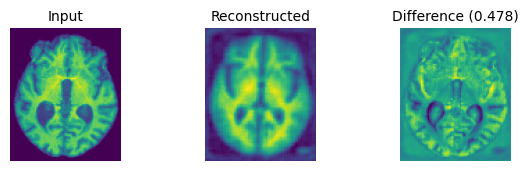

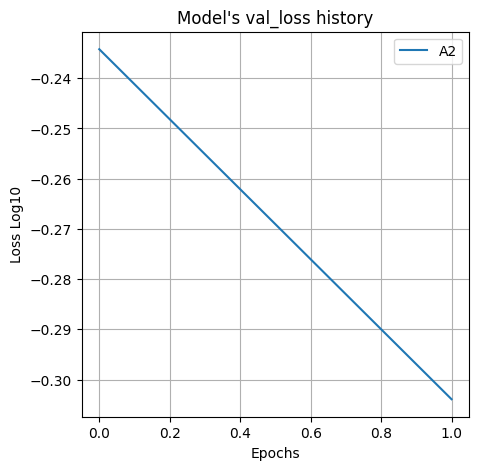

In [188]:

if 'models_list' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=groups["CN"], loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


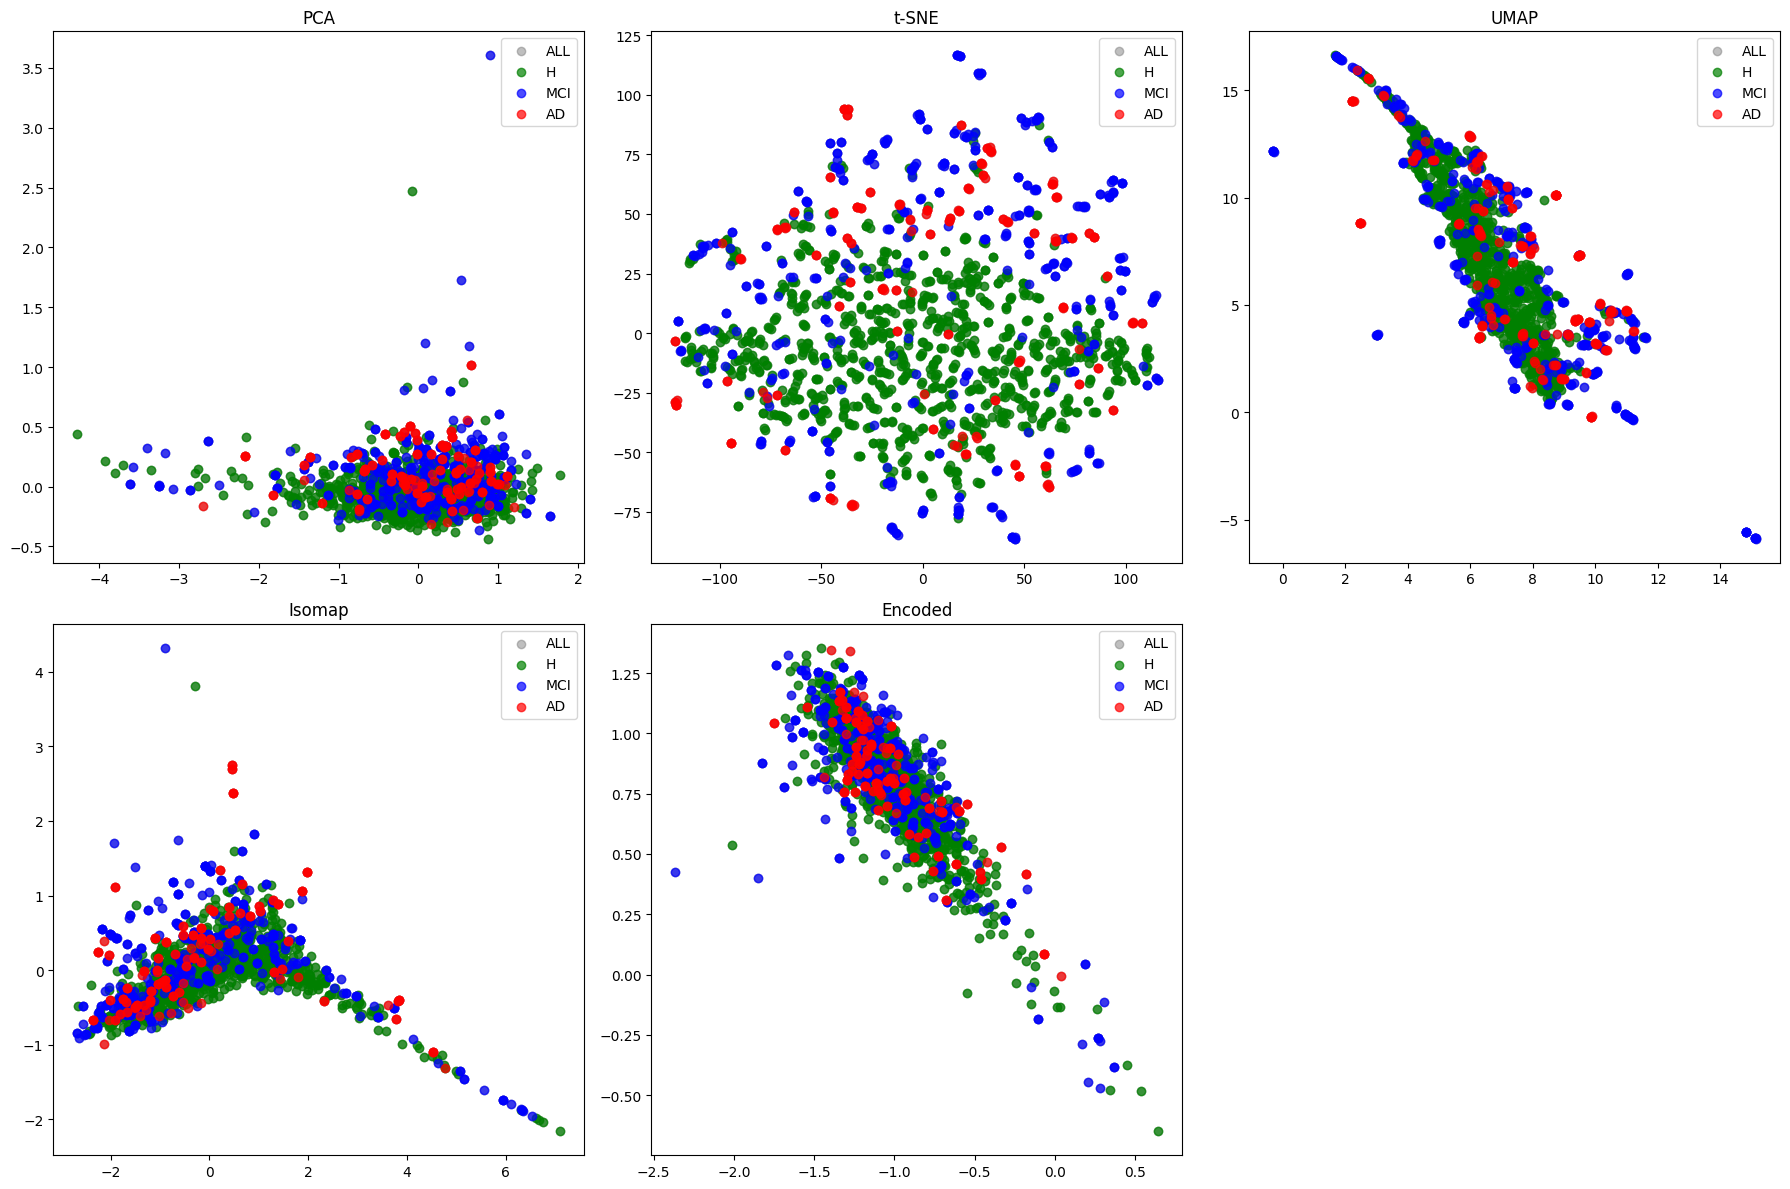

In [189]:
for m in models_list:
    plot_multiple_datasets( 
        model=m,
        plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP, pENCODED],
        datasets=[groups["CN"],groups["MCI"],groups["AD"]],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],#, "green", "blue"],
        titles=["PCA", "t-SNE", "UMAP", "Isomap", "Encoded"]
    )